In [1]:
import os
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier

In [2]:
# 1. 데이터 로드 및 초기 game list 생성
data_dir = './DATA'
games = []
for fn in os.listdir(data_dir):
    if not fn.endswith('.pickle'):
        continue
    path = os.path.join(data_dir, fn)
    with open(path, 'rb') as f:
        d = pickle.load(f)
    gi = d['GameInfo']
    score = d['Score']
    # 홈/어웨이 최종 득점과 승패
    home_row = score[score['팀명'] == gi['HOME_ID']].iloc[0]
    away_row = score[score['팀명'] == gi['AWAY_ID']].iloc[0]
    h_runs = home_row['R']
    a_runs = away_row['R']
    home_win = 1 if home_row['승패여부'] == '승' else 0
    games.append({
        'date': datetime.strptime(gi['GAME_DATE'], '%Y-%m-%d'),
        'home': gi['HOME_ID'],
        'away': gi['AWAY_ID'],
        'h_runs': h_runs,
        'a_runs': a_runs,
        'label': home_win
    })


In [3]:
# 2. 날짜 순 정렬
games = sorted(games, key=lambda x: x['date'])


In [4]:

# 3. 팀별 누적 통계 초기화
team_stats = {}
def ensure_team(t):
    if t not in team_stats:
        team_stats[t] = {
            'games': 0,
            'wins': 0,
            'runs_scored': 0,
            'runs_allowed': 0
        }


In [5]:

# 4. 피처 및 레이블 생성
feature_list = []
label_list = []
for g in games:
    h, a = g['home'], g['away']
    ensure_team(h); ensure_team(a)
    hs, ha = team_stats[h], team_stats[a]
    # 누적 기록이 없는 경우 중립값(0.5) 사용
    def win_rate(s): return s['wins']/s['games'] if s['games']>0 else 0.5
    def avg_scored(s): return s['runs_scored']/s['games'] if s['games']>0 else np.mean([gs['h_runs'] for gs in games])
    def avg_allowed(s): return s['runs_allowed']/s['games'] if s['games']>0 else np.mean([gs['a_runs'] for gs in games])
    feat = {
        'home_wr': win_rate(hs),
        'away_wr': win_rate(ha),
        'home_avg_scored': avg_scored(hs),
        'away_avg_scored': avg_scored(ha),
        'home_avg_allowed': avg_allowed(hs),
        'away_avg_allowed': avg_allowed(ha),
        'diff_wr': win_rate(hs) - win_rate(ha),
        'diff_avg_runs': avg_scored(hs) - avg_scored(ha)
    }
    feature_list.append(feat)
    label_list.append(g['label'])
    # 경기 결과 반영
    hs['games'] += 1
    ha['games'] += 1
    hs['wins'] += g['label']
    ha['wins'] += (1 - g['label'])
    hs['runs_scored'] += g['h_runs']
    hs['runs_allowed'] += g['a_runs']
    ha['runs_scored'] += g['a_runs']
    ha['runs_allowed'] += g['h_runs']


In [6]:

# 5. DataFrame 변환 및 Train/Test 분리
X = pd.DataFrame(feature_list)
y = np.array(label_list)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)


In [14]:
X

,home_wr,away_wr,home_avg_scored,away_avg_scored,home_avg_allowed,away_avg_allowed,diff_wr,diff_avg_runs
0,0.500000,0.500000,4.864070,4.864070,4.891432,4.891432,0.000000,0.000000
1,0.500000,0.500000,4.864070,4.864070,4.891432,4.891432,0.000000,0.000000
2,0.500000,0.500000,4.864070,4.864070,4.891432,4.891432,0.000000,0.000000
3,0.500000,0.500000,4.864070,4.864070,4.891432,4.891432,0.000000,0.000000
4,1.000000,0.000000,11.000000,6.000000,6.000000,11.000000,1.000000,5.000000
...,...,...,...,...,...,...,...,...
14760,0.540705,0.512791,5.100547,5.151163,4.746962,4.850581,0.027914,-0.050616
14761,0.529644,0.493703,4.882031,4.994962,4.670721,4.968934,0.035941,-0.112931
14762,0.437595,0.476158,4.528394,4.845368,5.286061,5.138965,-0.038563,-0.316974
14763,0.497568,0.493621,4.842857,4.753949,4.923708,4.777643,0.003947,0.088908


In [15]:
y

array([0, 1, 1, ..., 1, 1, 1], shape=(14765,))

In [7]:

# 6. 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


/opt/anaconda3/envs/Baseball/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:

# 7. 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f'Accuracy: {acc:.3f}')
print(f'ROC AUC: {auc:.3f}')


Accuracy: 0.501
ROC AUC: 0.498


In [9]:

# 8. 신규 경기 예측 함수
def predict_home_win_rate(home_id, away_id):
    ensure_team(home_id); ensure_team(away_id)
    hs, ha = team_stats[home_id], team_stats[away_id]
    feat = {
        'home_wr': hs['wins']/hs['games'] if hs['games']>0 else 0.5,
        'away_wr': ha['wins']/ha['games'] if ha['games']>0 else 0.5,
        'home_avg_scored': hs['runs_scored']/hs['games'] if hs['games']>0 else np.mean(X['home_avg_scored']),
        'away_avg_scored': ha['runs_scored']/ha['games'] if ha['games']>0 else np.mean(X['away_avg_scored']),
        'home_avg_allowed': hs['runs_allowed']/hs['games'] if hs['games']>0 else np.mean(X['home_avg_allowed']),
        'away_avg_allowed': ha['runs_allowed']/ha['games'] if ha['games']>0 else np.mean(X['away_avg_allowed']),
        'diff_wr': (hs['wins']/hs['games'] if hs['games']>0 else 0.5) - (ha['wins']/ha['games'] if ha['games']>0 else 0.5),
        'diff_avg_runs': (hs['runs_scored']/hs['games'] if hs['games']>0 else np.mean(X['home_avg_scored'])) 
                         - (ha['runs_scored']/ha['games'] if ha['games']>0 else np.mean(X['away_avg_scored']))
    }
    xf = pd.DataFrame([feat])
    return model.predict_proba(xf)[0, 1]


In [10]:

# 예시
print("SSG vs 키움 예측 홈 승률:", predict_home_win_rate('SK', 'WO'))


SSG vs 키움 예측 홈 승률: 0.5467006


#2

In [16]:
import os
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier

# 1. DATA 폴더 내 모든 경기 로드
DATA_DIR = './DATA'
games = []
for fn in os.listdir(DATA_DIR):
    if not fn.endswith('.pickle'):
        continue
    with open(os.path.join(DATA_DIR, fn), 'rb') as f:
        d = pickle.load(f)
    gi = d['GameInfo']
    score = d['Score']
    date = datetime.strptime(gi['GAME_DATE'], '%Y-%m-%d')
    h_id, a_id = gi['HOME_ID'], gi['AWAY_ID']
    # 점수 및 승패 레이블
    h_row = score[score['팀명']==h_id].iloc[0]
    a_row = score[score['팀명']==a_id].iloc[0]
    games.append({
        'date': date,
        'home': h_id, 'away': a_id,
        'h_runs': h_row['R'], 'a_runs': a_row['R'],
        'label': 1 if h_row['승패여부']=='승' else 0
    })

# 2. 날짜 순 정렬
games.sort(key=lambda x: x['date'])

# 3. 팀별 과거 경기 저장용
team_hist = {}
def ensure(team):
    if team not in team_hist:
        team_hist[team] = []

# 4. 피처·레이블 생성
X_list, y_list = [], []
for g in games:
    d, h, a, y = g['date'], g['home'], g['away'], g['label']
    ensure(h); ensure(a)

    # 4-1. 시즌 중 맞대결 승률 (home 기준)
    h2h = [m for m in team_hist.get((h,a),[]) if m['date']<d]
    h2h_wr = sum(m['label'] for m in h2h)/len(h2h) if h2h else 0.5

    # 4-2. 직전 5경기 승률·평균 득점 함수
    def last5_stats(team):
        past = [m for m in team_hist[team] if m['date']<d][-5:]
        if not past:
            return 0.5, np.mean([x['h_runs'] for x in games])
        wr = sum(m['label'] if m['home']==team else (1-m['label']) for m in past)/len(past)
        avg_r = np.mean([m['h_runs'] if m['home']==team else m['a_runs'] for m in past])
        return wr, avg_r

    home_wr5, home_avg5 = last5_stats(h)
    away_wr5, away_avg5 = last5_stats(a)

    # 4-3. 홈경기 여부
    home_ind = 1

    X_list.append({
        'h2h_wr': h2h_wr,
        'home_wr5': home_wr5,
        'home_avg5': home_avg5,
        'home_ind': home_ind
    })
    y_list.append(y)

    # 4-4. 기록 업데이트
    team_hist[h].append(g)
    team_hist[a].append(g)
    team_hist.setdefault((h,a), []).append(g)

# 5. DataFrame 변환·분할
X = pd.DataFrame(X_list)
y = np.array(y_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 7. 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test, y_prob))


Accuracy: 0.5231967490687437
ROC AUC : 0.5241879102882282


/opt/anaconda3/envs/Baseball/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:18:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
X

,h2h_wr,home_wr5,home_avg5,home_ind
0,0.500000,0.5,4.86407,1
1,0.500000,0.5,4.86407,1
2,0.500000,0.5,4.86407,1
3,0.500000,0.5,4.86407,1
4,1.000000,1.0,11.00000,1
...,...,...,...,...
14760,0.584158,0.8,9.20000,1
14761,0.618056,0.6,5.00000,1
14762,0.536585,0.6,3.80000,1
14763,0.523810,0.4,5.20000,1


In [18]:
y

array([0, 1, 1, ..., 1, 1, 1], shape=(14765,))

# 3

In [37]:
import os
import pickle
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier

'''
# 1. 구장별 득실점 편차(예시)
stadium_factors = {
    '문학': 0.05, '잠실': -0.03, '고척': 0.02, '사직': 0.01, '대구': -0.01, '광주': 0.00
}
'''

def parse_crowd(crowd_str):
    try:
        return int(str(crowd_str).replace(',', ''))
    except:
        return np.nan

# 2. 데이터 로드
DATA_DIR = './DATA'
games = []
for fn in os.listdir(DATA_DIR):
    if not fn.endswith('.pickle'):
        continue
    with open(os.path.join(DATA_DIR, fn), 'rb') as f:
        d = pickle.load(f)
    gi = d['GameInfo']
    score = d['Score']
    team1_hit = d['Team1_Hitter']
    team2_hit = d['Team2_Hitter']
    team1_pitch = d['Team1_Pitcher']
    team2_pitch = d['Team2_Pitcher']
    date = datetime.strptime(gi['GAME_DATE'], '%Y-%m-%d')
    home, away = gi['HOME_ID'], gi['AWAY_ID']
    stadium = gi['STADIUM']
    crowd = parse_crowd(gi['CROWD'])
    # 점수 및 승패
    home_row = score[score['팀명'] == home].iloc[0]
    away_row = score[score['팀명'] == away].iloc[0]
    h_runs = home_row['R']
    a_runs = away_row['R']
    home_win = 1 if home_row['승패여부'] == '승' else 0
    games.append({
        'date': date, 'home': home, 'away': away, 'stadium': stadium, 'crowd': crowd,
        'h_runs': h_runs, 'a_runs': a_runs, 'label': home_win,
        'team1_hit': team1_hit, 'team2_hit': team2_hit,
        'team1_pitch': team1_pitch, 'team2_pitch': team2_pitch
    })

games.sort(key=lambda x: x['date'])

# 2) Stadium_Factor 계산
df_games = pd.DataFrame(games)

# 2-1) 구장별 평균 홈 득점, 평균 원정 득점 계산
stadium_stats = df_games.groupby('stadium').agg({
    'h_runs': 'mean',
    'a_runs': 'mean'
}).rename(columns={'h_runs': 'mean_home_runs',
                   'a_runs': 'mean_away_runs'}).reset_index()

# 2-2) 득실점 편차 계산 (홈 득점 – 원정 득점)
stadium_stats['run_diff'] = stadium_stats['mean_home_runs'] - stadium_stats['mean_away_runs']

# 2-3) dict 형태로 변환
stadium_factors = dict(zip(stadium_stats['stadium'], stadium_stats['run_diff']))


# 3. 팀별 누적/최근 기록 및 상대전적 저장
team_stats = {}
head2head = {}

def ensure_team(t):
    if t not in team_stats:
        team_stats[t] = {
            'games': 0, 'wins': 0, 'runs_scored': 0, 'runs_allowed': 0, 'recent_games': [],
            'batting_avgs': [], 'obps': [], 'slgs': [],
            'pitcher_eras': [], 'pitcher_whips': [], 'pitcher_k_per9s': []
        }

def calc_batting_stats(hitter_df):
    batting_avg = hitter_df['타율'].dropna().astype(float).mean() if '타율' in hitter_df.columns else np.nan
    obp = hitter_df['출루율'].dropna().astype(float).mean() if '출루율' in hitter_df.columns else np.nan
    slg = hitter_df['장타율'].dropna().astype(float).mean() if '장타율' in hitter_df.columns else np.nan
    return batting_avg, obp, slg

def calc_pitcher_stats(pitcher_df):
    era = pitcher_df['평균자책점'].dropna().astype(float).mean() if '평균자책점' in pitcher_df.columns else np.nan
    hits = pitcher_df['피안타'].dropna().astype(float).sum() if '피안타' in pitcher_df.columns else 0
    walks = pitcher_df['4사구'].dropna().astype(float).sum() if '4사구' in pitcher_df.columns else 0
    innings = pitcher_df['이닝'].dropna().astype(float).sum() if '이닝' in pitcher_df.columns else 1
    whip = (hits + walks) / innings if innings > 0 else np.nan
    strikeouts = pitcher_df['삼진'].dropna().astype(float).sum() if '삼진' in pitcher_df.columns else 0
    k_per_9 = (strikeouts / innings) * 9 if innings > 0 else np.nan
    return era, whip, k_per_9

feature_list = []
label_list = []

for g in games:
    d, h, a = g['date'], g['home'], g['away']
    ensure_team(h)
    ensure_team(a)

    # 경기·환경 피처
    days_rest_home = (d - team_stats[h]['recent_games'][-1]['date']).days if team_stats[h]['recent_games'] else np.nan
    days_rest_away = (d - team_stats[a]['recent_games'][-1]['date']).days if team_stats[a]['recent_games'] else np.nan
    stadium_factor = stadium_factors.get(g['stadium'], 0)
    crowd_size = g['crowd']
    month = d.month
    weekday = d.weekday()

    # 팀 시즌 누적 성적
    def win_rate(t): return team_stats[t]['wins'] / team_stats[t]['games'] if team_stats[t]['games'] > 0 else 0.5
    def runs_per_game(t): return team_stats[t]['runs_scored'] / team_stats[t]['games'] if team_stats[t]['games'] > 0 else np.nan
    def runs_allowed_per_game(t): return team_stats[t]['runs_allowed'] / team_stats[t]['games'] if team_stats[t]['games'] > 0 else np.nan

    home_win_rate = win_rate(h)
    away_win_rate = win_rate(a)
    home_runs_per_game = runs_per_game(h)
    away_runs_per_game = runs_per_game(a)
    home_runs_allowed_per_game = runs_allowed_per_game(h)
    away_runs_allowed_per_game = runs_allowed_per_game(a)
    home_run_diff = home_runs_per_game - home_runs_allowed_per_game if not (np.isnan(home_runs_per_game) or np.isnan(home_runs_allowed_per_game)) else np.nan
    away_run_diff = away_runs_per_game - away_runs_allowed_per_game if not (np.isnan(away_runs_per_game) or np.isnan(away_runs_allowed_per_game)) else np.nan

    # 팀 최근 흐름 (직전 5경기)
    def last5_stats(t):
        recent = team_stats[t]['recent_games'][-5:]
        if not recent:
            return 0.5, np.nan, np.nan
        wr = sum(r['label'] if r['home'] == t else (1 - r['label']) for r in recent) / len(recent)
        avg_r = np.mean([r['h_runs'] if r['home'] == t else r['a_runs'] for r in recent])
        avg_ra = np.mean([r['a_runs'] if r['home'] == t else r['h_runs'] for r in recent])
        return wr, avg_r, avg_ra

    home_last5_wr, home_last5_r, home_last5_ra = last5_stats(h)
    away_last5_wr, away_last5_r, away_last5_ra = last5_stats(a)

    # 타자 집계 지표
    home_batting_avg, home_obp, home_slg = calc_batting_stats(g['team1_hit'])
    away_batting_avg, away_obp, away_slg = calc_batting_stats(g['team2_hit'])
    ops_lineup_diff = (home_obp + home_slg) - (away_obp + away_slg) if not (np.isnan(home_obp) or np.isnan(home_slg) or np.isnan(away_obp) or np.isnan(away_slg)) else np.nan

    # 선발 투수 지표
    sp_era_home, sp_whip_home, sp_k_per9_home = calc_pitcher_stats(g['team1_pitch'])
    sp_era_away, sp_whip_away, sp_k_per9_away = calc_pitcher_stats(g['team2_pitch'])




    
    # 직전 3경기 ERA (간단 예시)
    def recent_era(t):
        eras = team_stats[t]['pitcher_eras'][-3:]
        return np.mean([e for e in eras if not np.isnan(e)]) if eras else np.nan
    sp_recent_era_home = recent_era(h)
    sp_recent_era_away = recent_era(a)





    sp_days_rest_home = days_rest_home
    sp_days_rest_away = days_rest_away

    # 불펜 지표(예시: 최근 3경기 ERA, 이닝)
    bullpen_ERA_home = np.mean(team_stats[h]['pitcher_eras'][-3:]) if team_stats[h]['pitcher_eras'] else np.nan
    bullpen_ERA_away = np.mean(team_stats[a]['pitcher_eras'][-3:]) if team_stats[a]['pitcher_eras'] else np.nan
    bullpen_inn_home = np.sum(team_stats[h]['pitcher_k_per9s'][-3:]) if team_stats[h]['pitcher_k_per9s'] else np.nan
    bullpen_inn_away = np.sum(team_stats[a]['pitcher_k_per9s'][-3:]) if team_stats[a]['pitcher_k_per9s'] else np.nan
    long_relief_ERA_diff = bullpen_ERA_home - sp_era_home if not (np.isnan(bullpen_ERA_home) or np.isnan(sp_era_home)) else np.nan

    # 상대전적 및 심리적 요소
    h2h_key = (h, a)
    h2h_games = head2head.get(h2h_key, [])
    if h2h_games:
        head2head_wr = sum(gm['label'] for gm in h2h_games) / len(h2h_games)
        last_h2h_margin = h2h_games[-1]['h_runs'] - h2h_games[-1]['a_runs']
    else:
        head2head_wr = 0.5
        last_h2h_margin = 0

    # 라인업 일관성(예시: 항상 1.0, 실제로는 라인업 비교 필요)
    lineup_consistency = 1.0

    feat = {
        'days_rest_home': days_rest_home,
        'days_rest_away': days_rest_away,
        'stadium_factor': stadium_factor,
        'crowd_size': crowd_size,
        'month': month,
        'weekday': weekday,
        'home_win_rate': home_win_rate,
        'away_win_rate': away_win_rate,
        'home_runs_per_game': home_runs_per_game,
        'away_runs_per_game': away_runs_per_game,
        'home_runs_allowed_per_game': home_runs_allowed_per_game,
        'away_runs_allowed_per_game': away_runs_allowed_per_game,
        'home_run_diff': home_run_diff,
        'away_run_diff': away_run_diff,
        'home_last5_wr': home_last5_wr,
        'away_last5_wr': away_last5_wr,
        'home_last5_r': home_last5_r,
        'away_last5_r': away_last5_r,
        'home_last5_ra': home_last5_ra,
        'away_last5_ra': away_last5_ra,
        'avg_batting_avg_home': home_batting_avg,
        'avg_batting_avg_away': away_batting_avg,
        'sum_OBP_home': home_obp,
        'sum_OBP_away': away_obp,
        'sum_SLG_home': home_slg,
        'sum_SLG_away': away_slg,
        'OPS_lineup_diff': ops_lineup_diff,
        'SP_ERA_home': sp_era_home,
        'SP_ERA_away': sp_era_away,
        'SP_WHIP_home': sp_whip_home,
        'SP_WHIP_away': sp_whip_away,
        'SP_K_per9_home': sp_k_per9_home,
        'SP_K_per9_away': sp_k_per9_away,
        'SP_recent_era_home': sp_recent_era_home,
        'SP_recent_era_away': sp_recent_era_away,
        'SP_days_rest_home': sp_days_rest_home,
        'SP_days_rest_away': sp_days_rest_away,
        'bullpen_ERA_home': bullpen_ERA_home,
        'bullpen_ERA_away': bullpen_ERA_away,
        'bullpen_inn_home': bullpen_inn_home,
        'bullpen_inn_away': bullpen_inn_away,
        'long_relief_ERA_diff': long_relief_ERA_diff,
        'head2head_wr': head2head_wr,
        'last_head2head_margin': last_h2h_margin,
        'lineup_consistency': lineup_consistency
    }
    feature_list.append(feat)
    label_list.append(g['label'])

    # 누적 기록 업데이트
    team_stats[h]['games'] += 1
    team_stats[h]['wins'] += g['label']
    team_stats[h]['runs_scored'] += g['h_runs']
    team_stats[h]['runs_allowed'] += g['a_runs']
    team_stats[h]['recent_games'].append(g)
    team_stats[h]['batting_avgs'].append(home_batting_avg)
    team_stats[h]['obps'].append(home_obp)
    team_stats[h]['slgs'].append(home_slg)
    team_stats[h]['pitcher_eras'].append(sp_era_home)
    team_stats[h]['pitcher_whips'].append(sp_whip_home)
    team_stats[h]['pitcher_k_per9s'].append(sp_k_per9_home)
    team_stats[a]['games'] += 1
    team_stats[a]['wins'] += (1 - g['label'])
    team_stats[a]['runs_scored'] += g['a_runs']
    team_stats[a]['runs_allowed'] += g['h_runs']
    team_stats[a]['recent_games'].append(g)
    team_stats[a]['batting_avgs'].append(away_batting_avg)
    team_stats[a]['obps'].append(away_obp)
    team_stats[a]['slgs'].append(away_slg)
    team_stats[a]['pitcher_eras'].append(sp_era_away)
    team_stats[a]['pitcher_whips'].append(sp_whip_away)
    team_stats[a]['pitcher_k_per9s'].append(sp_k_per9_away)
    if h2h_key not in head2head:
        head2head[h2h_key] = []
    head2head[h2h_key].append(g)

# 4. DataFrame 변환 및 결측치 처리
X = pd.DataFrame(feature_list)
y = pd.Series(label_list)
X.fillna(X.mean(), inplace=True)

# 5. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. XGBoost 모델 학습 및 평가
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test, y_prob))


/opt/anaconda3/envs/Baseball/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:30:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.813748730104978
ROC AUC : 0.8984966993444563


In [30]:
X

,days_rest_home,days_rest_away,stadium_factor,crowd_size,month,weekday,home_win_rate,away_win_rate,home_runs_per_game,away_runs_per_game,...,SP_days_rest_home,SP_days_rest_away,bullpen_ERA_home,bullpen_ERA_away,bullpen_inn_home,bullpen_inn_away,long_relief_ERA_diff,head2head_wr,last_head2head_margin,lineup_consistency
0,2.65481,2.644691,-0.151643,12335,4,3,0.500000,0.500000,4.788825,4.789958,...,2.65481,2.644691,4.382359,4.389532,50.265617,49.474939,-0.038249,0.500000,0,1.0
1,2.65481,2.644691,0.144505,30500,4,3,0.500000,0.500000,4.788825,4.789958,...,2.65481,2.644691,4.382359,4.389532,50.265617,49.474939,-0.038249,0.500000,0,1.0
2,2.65481,2.644691,-0.305556,11405,4,3,0.500000,0.500000,4.788825,4.789958,...,2.65481,2.644691,4.382359,4.389532,50.265617,49.474939,-0.038249,0.500000,0,1.0
3,2.65481,2.644691,0.433962,13000,4,3,0.500000,0.500000,4.788825,4.789958,...,2.65481,2.644691,4.382359,4.389532,50.265617,49.474939,-0.038249,0.500000,0,1.0
4,1.00000,1.000000,-0.305556,3200,4,4,1.000000,0.000000,11.000000,6.000000,...,1.00000,1.000000,22.125000,5.253333,6.428571,72.000000,9.747000,1.000000,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,1.00000,1.000000,0.134134,24000,4,6,0.540705,0.512791,5.100547,5.151163,...,1.00000,1.000000,10.018667,3.117500,119.250000,35.300000,5.728667,0.584158,8,1.0
14761,1.00000,1.000000,0.218413,16422,4,6,0.529644,0.493703,4.882031,4.994962,...,1.00000,1.000000,4.244738,3.465556,32.100000,163.500000,0.179738,0.618056,-1,1.0
14762,1.00000,1.000000,2.142857,17000,4,6,0.437595,0.476158,4.528394,4.845368,...,1.00000,1.000000,2.738222,2.574722,34.500000,49.474939,0.334889,0.536585,1,1.0
14763,1.00000,1.000000,-0.055069,20500,4,6,0.497568,0.493621,4.842857,4.753949,...,1.00000,1.000000,3.370889,7.428889,66.600000,34.500000,1.618389,0.523810,4,1.0


In [28]:
y

0        0
1        1
2        1
3        1
4        1
        ..
14760    1
14761    0
14762    1
14763    1
14764    1
Name: label, Length: 14765, dtype: int64

/var/folders/y0/q03jfyf535q18hk6cqtmf9080000gn/T/ipykernel_9992/2216942758.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_sorted.values, y=corr_sorted.index, palette='coolwarm')


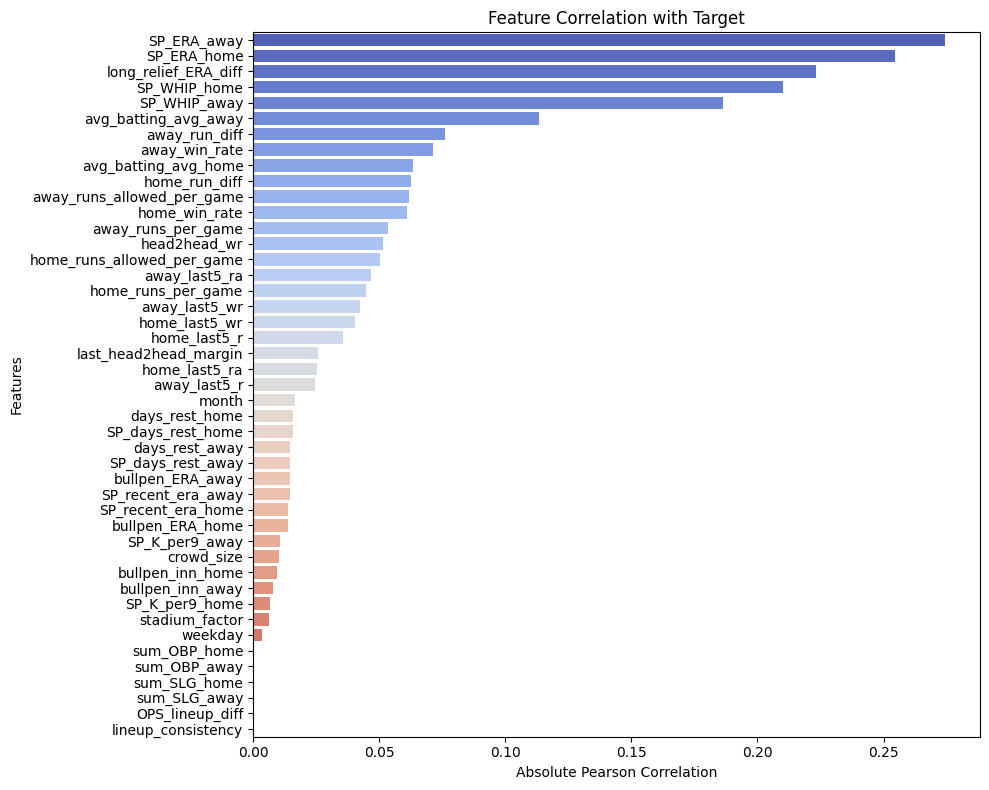

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# X(DataFrame)와 y(Series)가 이미 정의되어 있다고 가정
# y 이름이 'label'이라고 가정하되, 아닐 경우 아래 rename 부분을 수정하세요.
y = y.rename('label')

# 1. X와 y 합치기
df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

# 2. 상관계수 계산
corr = df.corr()

# 3. 타깃(label)과의 상관계수만 추출하고 자기 자신은 제외
corr_with_target = corr['label'].drop('label')

# 4. 절댓값 기준 내림차순 정렬
corr_sorted = corr_with_target.abs().sort_values(ascending=False)

# 5. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_sorted.values, y=corr_sorted.index, palette='coolwarm')
plt.title('Feature Correlation with Target')
plt.xlabel('Absolute Pearson Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


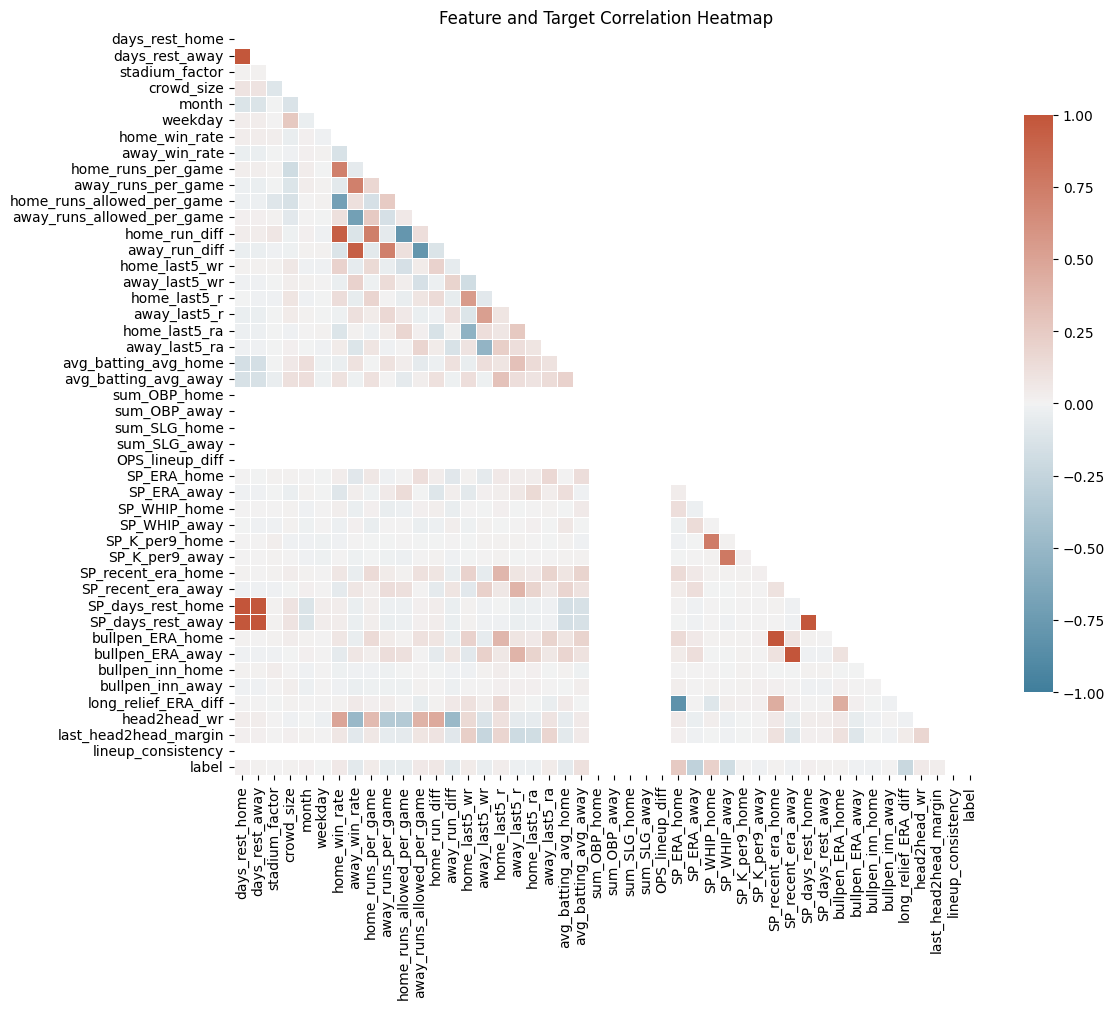

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# X(DataFrame), y(Series)가 이미 정의되어 있다고 가정
full_df = pd.concat([X.reset_index(drop=True),
                     y.reset_index(drop=True).rename('label')],
                    axis=1)

# 상관계수 및 마스크 생성
corr = full_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# 히트맵 시각화 (annotation=False로 숫자 제거)
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmin=-1, vmax=1, center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .75},
    annot=False            # 숫자 표시하지 않음[2]
)
plt.title('Feature and Target Correlation Heatmap')
plt.show()


# 4

In [38]:
import os
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier

# --- 유틸리티 함수들 ---
def parse_crowd(crowd_str):
    try:
        return int(str(crowd_str).replace(',', ''))
    except:
        return np.nan

def calc_batting_stats(df_hit):
    df = df_hit.copy()
    # 타율
    if '타율' in df.columns:
        df['타율'] = pd.to_numeric(df['타율'], errors='coerce')
        avg = df['타율'].mean()
    else:
        avg = np.nan
    # 출루율이 없으면 안타/타수로 대체
    if '출루율' in df.columns:
        df['출루율'] = pd.to_numeric(df['출루율'], errors='coerce')
        obp = df['출루율'].mean()
    else:
        obp = (df['안타'] / df['타수']).replace([np.inf, -np.inf], np.nan).fillna(0).mean()
    # 장타율이 없으면 안타/타수로 대체
    if '장타율' in df.columns:
        df['장타율'] = pd.to_numeric(df['장타율'], errors='coerce')
        slg = df['장타율'].mean()
    else:
        slg = obp  # 대체: same as obp
    return avg, obp, slg

def calc_pitcher_stats(df_pit):
    df = df_pit.copy()
    df['평균자책점'] = pd.to_numeric(df.get('평균자책점', pd.Series()), errors='coerce')
    df['이닝'] = pd.to_numeric(df.get('이닝', pd.Series()), errors='coerce').fillna(0)
    df['피안타'] = pd.to_numeric(df.get('피안타', pd.Series()), errors='coerce').fillna(0)
    df['4사구'] = pd.to_numeric(df.get('4사구', pd.Series()), errors='coerce').fillna(0)
    df['삼진'] = pd.to_numeric(df.get('삼진', pd.Series()), errors='coerce').fillna(0)
    # 선발투수
    sp = df[df['등판'] == '선발']
    era_sp = sp['평균자책점'].iloc[0] if not sp.empty else np.nan
    # 불펜
    rp = df[df['등판'] != '선발']
    total_inn = rp['이닝'].sum()
    era_bp = (rp['평균자책점'] * rp['이닝']).sum() / total_inn if total_inn > 0 else np.nan
    return era_sp, era_bp, total_inn

def extract_lineup(df_hit):
    df = df_hit[df_hit['타수'] > 0]
    return set(df['선수명']) if '선수명' in df.columns else set()

def recent_sp_era(team, date, n=3):
    recs = [r['era'] for r in reversed(team_stats[team]['sp_apps'])
            if r['date'] < date and not np.isnan(r['era'])]
    return np.mean(recs[:n]) if recs else np.nan

# --- 1. 경기 데이터 로드 및 정렬 ---
DATA_DIR = './DATA'
games = []
for fn in os.listdir(DATA_DIR):
    if not fn.endswith('.pickle'):
        continue
    with open(os.path.join(DATA_DIR, fn), 'rb') as f:
        d = pickle.load(f)
    gi, score = d['GameInfo'], d['Score']
    date = datetime.strptime(gi['GAME_DATE'], '%Y-%m-%d')
    home, away = gi['HOME_ID'], gi['AWAY_ID']
    h_row = score[score['팀명'] == home].iloc[0]
    a_row = score[score['팀명'] == away].iloc[0]
    games.append({
        'date': date,
        'home': home, 'away': away,
        'stadium': gi['STADIUM'],
        'crowd': parse_crowd(gi['CROWD']),
        'h_runs': h_row['R'], 'a_runs': a_row['R'],
        'label': 1 if h_row['승패여부'] == '승' else 0,
        'hit_home': d['Team1_Hitter'], 'hit_away': d['Team2_Hitter'],
        'pit_home': d['Team1_Pitcher'], 'pit_away': d['Team2_Pitcher']
    })
games.sort(key=lambda x: x['date'])

# --- 2. 구장별 득실점 편차 계산 ---
df_g = pd.DataFrame([{'stadium': g['stadium'], 'h_runs': g['h_runs'], 'a_runs': g['a_runs']} for g in games])
stadium_stats = df_g.groupby('stadium').mean().reset_index()
stadium_stats['run_diff'] = stadium_stats['h_runs'] - stadium_stats['a_runs']
stadium_factors = dict(zip(stadium_stats['stadium'], stadium_stats['run_diff']))

# --- 3. 팀별 누적·최근 통계 및 상대전적 초기화 ---
team_stats = {}
head2head = {}
def ensure_team(t):
    if t not in team_stats:
        team_stats[t] = {
            'games': 0, 'wins': 0,
            'runs_scored': 0, 'runs_allowed': 0,
            'recent_games': [],
            'sp_apps': [],  # {'date','era'}
            'bp_eras': [], 'bp_inns': [],
            'last_lineup': None
        }

# --- 4. 피처 생성 루프 ---
feature_list, label_list = [], []
for g in games:
    d, h, a = g['date'], g['home'], g['away']
    ensure_team(h); ensure_team(a)

    # 환경
    drh = (d - team_stats[h]['recent_games'][-1]['date']).days if team_stats[h]['recent_games'] else np.nan
    dra = (d - team_stats[a]['recent_games'][-1]['date']).days if team_stats[a]['recent_games'] else np.nan
    sf = stadium_factors.get(g['stadium'], 0)
    cs, m, wd = g['crowd'], d.month, d.weekday()

    # 시즌 누적
    wr = lambda t: team_stats[t]['wins']/team_stats[t]['games'] if team_stats[t]['games']>0 else 0.5
    rpg = lambda t: team_stats[t]['runs_scored']/team_stats[t]['games'] if team_stats[t]['games']>0 else np.nan
    rapg = lambda t: team_stats[t]['runs_allowed']/team_stats[t]['games'] if team_stats[t]['games']>0 else np.nan
    hwr, awr = wr(h), wr(a)
    hrpg, arpg = rpg(h), rpg(a)
    hrapg, arapg = rapg(h), rapg(a)
    hdiff, adiff = hrpg-hrapg, arpg-arapg

    # 최근 5경기 모멘텀
    def last5(t):
        rec = team_stats[t]['recent_games'][-5:]
        if not rec:
            return 0.5, np.nan, np.nan
        win = sum(r['label'] if r['home']==t else 1-r['label'] for r in rec)/len(rec)
        rs = np.mean([r['h_runs'] if r['home']==t else r['a_runs'] for r in rec])
        ra = np.mean([r['a_runs'] if r['home']==t else r['h_runs'] for r in rec])
        return win, rs, ra
    h5wr, h5r, h5ra = last5(h)
    a5wr, a5r, a5ra = last5(a)

    # 타자 집계
    bav_h, obp_h, slg_h = calc_batting_stats(g['hit_home'])
    bav_a, obp_a, slg_a = calc_batting_stats(g['hit_away'])
    ops_diff = (obp_h+slg_h) - (obp_a+slg_a)

    # 투수 집계
    sp_h, bp_h, inn_h = calc_pitcher_stats(g['pit_home'])
    sp_a, bp_a, inn_a = calc_pitcher_stats(g['pit_away'])
    sp3h = recent_sp_era(h, d, 3)
    sp3a = recent_sp_era(a, d, 3)

    # 라인업 일관성
    lu_h = extract_lineup(g['hit_home'])
    lu_a = extract_lineup(g['hit_away'])
    prev_h = team_stats[h]['last_lineup']
    prev_a = team_stats[a]['last_lineup']
    cons_h = len(lu_h & prev_h)/len(lu_h | prev_h) if prev_h else np.nan
    cons_a = len(lu_a & prev_a)/len(lu_a | prev_a) if prev_a else np.nan

    # 상대전적
    key = (h, a)
    hh = head2head.get(key, [])
    h2h_wr = sum(x['label'] for x in hh)/len(hh) if hh else 0.5
    h2h_margin = (hh[-1]['h_runs']-hh[-1]['a_runs']) if hh else 0

    feat = {
        'days_rest_home': drh, 'days_rest_away': dra,
        'stadium_factor': sf, 'crowd_size': cs,
        'month': m, 'weekday': wd,
        'home_win_rate': hwr, 'away_win_rate': awr,
        'home_runs_per_game': hrpg, 'away_runs_per_game': arpg,
        'home_runs_allowed_per_game': hrapg, 'away_runs_allowed_per_game': arapg,
        'home_run_diff': hdiff, 'away_run_diff': adiff,
        'home_last5_wr': h5wr, 'away_last5_wr': a5wr,
        'home_last5_r': h5r, 'away_last5_r': a5r,
        'home_last5_ra': h5ra, 'away_last5_ra': a5ra,
        'avg_batting_avg_home': bav_h, 'avg_batting_avg_away': bav_a,
        'sum_OBP_home': obp_h, 'sum_OBP_away': obp_a,
        'sum_SLG_home': slg_h, 'sum_SLG_away': slg_a,
        'OPS_lineup_diff': ops_diff,
        'SP_ERA_home': sp_h, 'SP_ERA_away': sp_a,
        'SP_recent_era_home': sp3h, 'SP_recent_era_away': sp3a,
        'bullpen_ERA_home': np.nanmean(team_stats[h]['bp_eras']) if team_stats[h]['bp_eras'] else np.nan,
        'bullpen_ERA_away': np.nanmean(team_stats[a]['bp_eras']) if team_stats[a]['bp_eras'] else np.nan,
        'bullpen_inn_home': np.nansum(team_stats[h]['bp_inns']),
        'bullpen_inn_away': np.nansum(team_stats[a]['bp_inns']),
        'long_relief_ERA_diff': bp_h - sp_h,
        'head2head_wr': h2h_wr,
        'last_head2head_margin': h2h_margin,
        'lineup_consistency_home': cons_h,
        'lineup_consistency_away': cons_a
    }
    feature_list.append(feat)
    label_list.append(g['label'])

    # 누적 업데이트
    ts_h, ts_a = team_stats[h], team_stats[a]
    ts_h['games'] += 1; ts_h['wins'] += g['label']
    ts_h['runs_scored'] += g['h_runs']; ts_h['runs_allowed'] += g['a_runs']
    ts_h['recent_games'].append(g)
    ts_h['sp_apps'].append({'date': d, 'era': sp_h})
    ts_h['bp_eras'].append(bp_h); ts_h['bp_inns'].append(inn_h)
    ts_h['last_lineup'] = lu_h

    ts_a['games'] += 1; ts_a['wins'] += 1-g['label']
    ts_a['runs_scored'] += g['a_runs']; ts_a['runs_allowed'] += g['h_runs']
    ts_a['recent_games'].append(g)
    ts_a['sp_apps'].append({'date': d, 'era': sp_a})
    ts_a['bp_eras'].append(bp_a); ts_a['bp_inns'].append(inn_a)
    ts_a['last_lineup'] = lu_a

    head2head.setdefault(key, []).append(g)

# --- 5. 모델 학습 및 평가 ---
X = pd.DataFrame(feature_list).fillna(0)
y = pd.Series(label_list)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# use_label_encoder 제거, eval_metric만 지정
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test, y_prob))


/var/folders/y0/q03jfyf535q18hk6cqtmf9080000gn/T/ipykernel_9992/179393139.py:184: RuntimeWarning: Mean of empty slice
  'bullpen_ERA_home': np.nanmean(team_stats[h]['bp_eras']) if team_stats[h]['bp_eras'] else np.nan,


Accuracy: 0.7395868608195056
ROC AUC : 0.8220774633349697


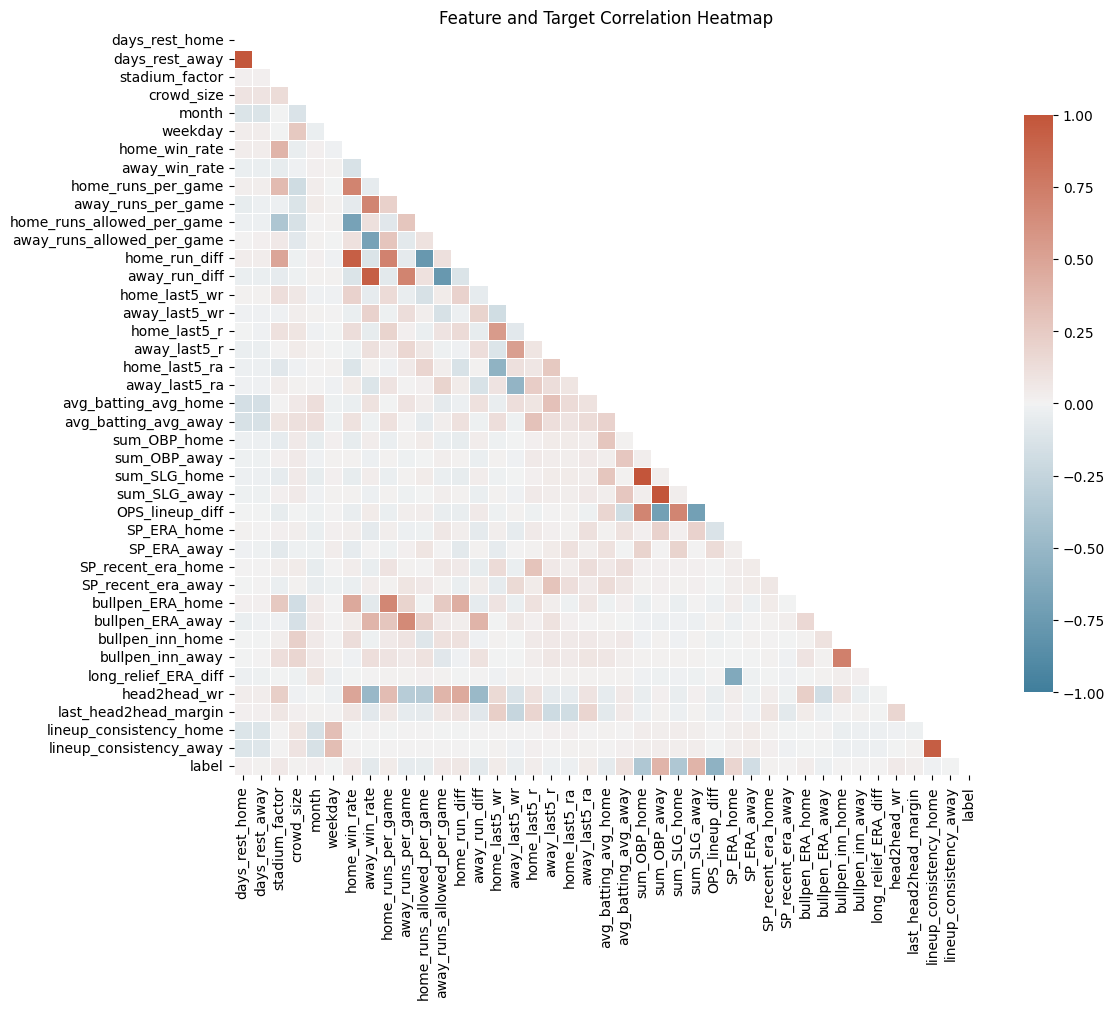

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# X(DataFrame), y(Series)가 이미 정의되어 있다고 가정
full_df = pd.concat([X.reset_index(drop=True),
                     y.reset_index(drop=True).rename('label')],
                    axis=1)

# 상관계수 및 마스크 생성
corr = full_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# 히트맵 시각화 (annotation=False로 숫자 제거)
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmin=-1, vmax=1, center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .75},
    annot=False            # 숫자 표시하지 않음[2]
)
plt.title('Feature and Target Correlation Heatmap')
plt.show()


In [45]:
X

,days_rest_home,days_rest_away,stadium_factor,crowd_size,month,weekday,home_win_rate,away_win_rate,home_runs_per_game,away_runs_per_game,...,SP_recent_era_away,bullpen_ERA_home,bullpen_ERA_away,bullpen_inn_home,bullpen_inn_away,long_relief_ERA_diff,head2head_wr,last_head2head_margin,lineup_consistency_home,lineup_consistency_away
0,0.0,0.0,-0.151643,12335,4,3,0.500000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,-1.500,0.500000,0,0.000000,0.000000
1,0.0,0.0,0.144505,30500,4,3,0.500000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.500000,0,0.000000,0.000000
2,0.0,0.0,-0.305556,11405,4,3,0.500000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,-5.250,0.500000,0,0.000000,0.000000
3,0.0,0.0,0.433962,13000,4,3,0.500000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,15.160,0.500000,0,0.000000,0.000000
4,1.0,1.0,-0.305556,3200,4,4,1.000000,0.000000,11.000000,6.000000,...,3.380000,6.000000,9.000000,3.0,1.0,-11.570,1.000000,5,0.818182,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,1.0,1.0,0.134134,24000,4,6,0.540705,0.512791,5.100547,5.151163,...,3.540000,4.193828,4.366556,6084.0,3654.0,-1.755,0.584158,8,0.571429,0.533333
14761,1.0,1.0,0.218413,16422,4,6,0.529644,0.493703,4.882031,4.994962,...,3.330000,4.144749,4.160994,6018.0,4702.0,1.100,0.618056,-1,0.533333,0.750000
14762,1.0,1.0,2.142857,17000,4,6,0.437595,0.476158,4.528394,4.845368,...,3.656667,3.987540,4.191169,6286.0,3221.0,-0.850,0.536585,1,0.769231,0.727273
14763,1.0,1.0,-0.055069,20500,4,6,0.497568,0.493621,4.842857,4.753949,...,5.026667,4.077607,4.034415,6340.0,5963.0,0.000,0.523810,4,0.642857,0.666667


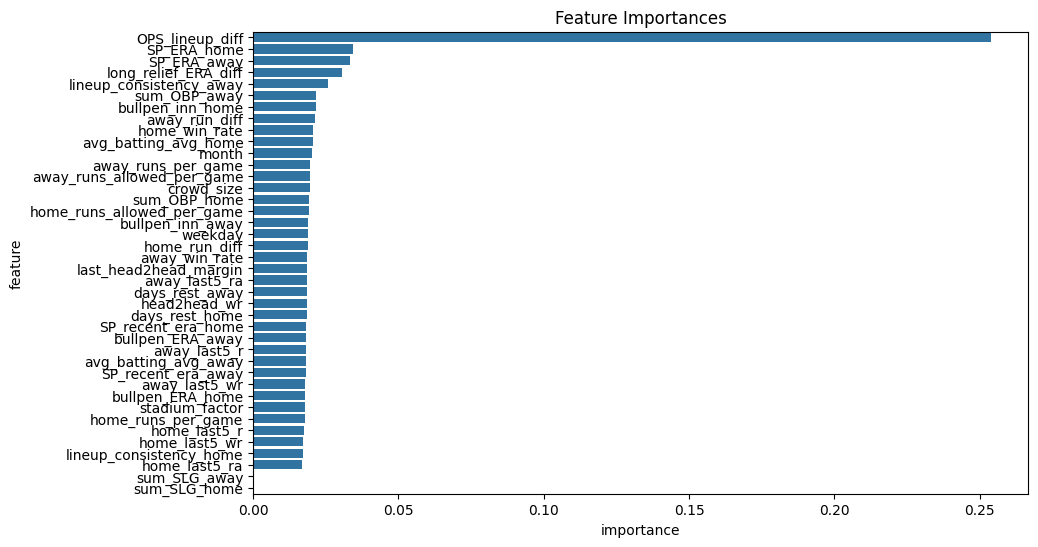

타깃과 상관관계 낮은 피처: ['bullpen_inn_away', 'long_relief_ERA_diff', 'SP_recent_era_away', 'weekday', 'bullpen_inn_home', 'lineup_consistency_away', 'SP_recent_era_home', 'lineup_consistency_home', 'crowd_size', 'days_rest_away', 'days_rest_home', 'month', 'away_last5_r', 'home_last5_ra', 'last_head2head_margin', 'bullpen_ERA_away', 'home_last5_r', 'bullpen_ERA_home', 'home_last5_wr', 'away_last5_wr', 'home_runs_per_game', 'away_last5_ra', 'home_runs_allowed_per_game']
피처 간 상관관계 높은 쌍: [('days_rest_home', 'days_rest_away', np.float64(0.9854501768642863)), ('home_win_rate', 'home_run_diff', np.float64(0.9350715729342957)), ('away_win_rate', 'away_run_diff', np.float64(0.9372509455795724)), ('sum_OBP_home', 'sum_SLG_home', np.float64(1.0)), ('sum_OBP_away', 'sum_SLG_away', np.float64(1.0)), ('lineup_consistency_home', 'lineup_consistency_away', np.float64(0.9423678483717166))]


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 1) 모델 학습
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# 2) 피처 중요도 시각화
fi = model.feature_importances_
fi_df = pd.DataFrame({'feature': X.columns, 'importance': fi})
fi_df = fi_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title('Feature Importances')
plt.show()

# 3) 타깃과 피처 상관관계 구하기
full = pd.concat([X, y.rename('label')], axis=1)
corr_with_target = full.corr()['label'].abs().sort_values()

# 4) 상관관계 기준으로 제거候補
low_corr = corr_with_target[corr_with_target < 0.05].index.tolist()

# 5) 피처 간 다중공선성 파악
corr_matrix = X.corr().abs()
high_corr_pairs = []
for i, f1 in enumerate(X.columns):
    for j, f2 in enumerate(X.columns[i+1:], i+1):
        if corr_matrix.iloc[i,j] > 0.9:
            high_corr_pairs.append((f1, f2, corr_matrix.iloc[i,j]))

print("타깃과 상관관계 낮은 피처:", low_corr)
print("피처 간 상관관계 높은 쌍:", high_corr_pairs)
